In [1]:
#using Pkg
#Pkg.activate("D:\\Science\\Code\\Julia\\envr")
using StaticArrays, DifferentialEquations, DynamicalSystems, JLD, CairoMakie

In [2]:
function TM(u, p, t)

    U(y) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
    σ(x) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
    
    # u[1] - E; u[2] - x; u[3] - y
    # α - 1, τ - 2, τD - 3, τy - 4, J - 5, xthr - 6, ythr - 7, U0 - 8, ΔU0 - 9, β - 10, I0 -11

    du1 = (-u[1] + p[1] * log( 1.0 + exp( (p[5] * U(u[3]) * u[2] * u[1] + p[11]  ) / (p[1]) ) ) ) / p[2]
    du2 = (1.0 - u[2])/p[3] - U(u[3])*u[2]*u[1]
    du3 = (-u[3])/p[4] + p[10] * σ(u[2])
    return SA[du1, du2, du3]
end;

In [3]:
t = 500.0; tstep = 0.001
trange = range(0.0, t, step = tstep)
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

In [4]:
const τ = 0.013;  const τD = 0.080;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58; const ΔU0 = 0.305;

In [5]:
I0range = range( -1.40, -1.709, length = 201 )
U0range = range( 0.3,  0.47, length = 201)

0.3:0.00085:0.47

In [6]:
path = "C:\\Users\\Alex\\Desktop\\repo\\2612\\0903\\dynamical-systems\\Tsodyks Markram\\Levanova\\3 набор параметров\\2М Карта спектра Ляпуновских показателей\\200x200";
filenameLS = "\\LSs_200x200.jld"
filenameu0s = "\\u0s_200x200.jld"
pathLS = path*filenameLS
pathu0s = path*filenameu0s;

In [7]:
Λs = load(pathLS)["data"]
u0s = load(pathu0s)["data"];

In [8]:
modes = zeros(201, 201);

In [9]:
function check_chaos_mode(idx_I0, idx_U0)
    chaos = 0
    if Λs[idx_I0, idx_U0, 1] >= 0.1
            chaos = 3
    end
    return chaos
end
function local_min(tr)
    
    localmin = Float64[]
    placeintime = Float64[]
    
    for idx in range(2, length(tr) - 1, step = 1)
        if tr[idx-1] > tr[idx] < tr[idx+1]
            push!(localmin, tr[idx])
            push!(placeintime, trange[idx])
        end
    end
    return localmin, placeintime
end
function traj(idx_I0, idx_U0)
    
    E, x, y = u0s[idx_I0, idx_U0, :]
    u0 = SA[E, x, y]
    I0_ = I0range[idx_I0]
    U0_ = U0range[idx_U0]
    p = SA[α, τ, τD, τy, J, xthr, ythr, U0_, ΔU0, β, I0_]
    ds = ContinuousDynamicalSystem(TM, u0, p)
    tr = trajectory(ds, t; diffeq = integ_set)
    
    return tr[:, 1]
end
function detect_mode(idx_I0, idx_U0)
    
    mode = check_chaos_mode(idx_I0, idx_U0)
    if mode == 0
        tr = traj(idx_I0, idx_U0)
        lcmin, _ = local_min(tr)
        if abs(maximum(lcmin) - minimum(lcmin)) > 2
            mode = 2
        else
            mode = 1
        end
    end
    return mode
end

detect_mode (generic function with 1 method)

In [10]:
function output(idx_U0, U0, idx_I0, I0, mode)
    println("index U0: $idx_U0; index I0: $idx_I0");flush(stdout)
    println("U0: $U0");flush(stdout)
    println("I0: $I0");flush(stdout)
    println("Mode: $mode");flush(stdout)
end
function separate()
    println("");flush(stdout)
    println("----------------");flush(stdout)
end

separate (generic function with 1 method)

In [11]:
idxI0 = 90; idxU0 = 1
E, x, y = u0s[idxI0, idxU0, :]
u0 = SA[E, x, y]
p = SA[α, τ, τD, τy, J, xthr, ythr, U0range[idxU0], ΔU0, β, I0range[idxI0]];

In [12]:
Λs[idxI0, idxU0, :]

3-element Vector{Float64}:
  0.001878280258316038
 -1.536370413919485
 -2.767665641148319

In [13]:
ds = ContinuousDynamicalSystem(TM, u0, p)

3-dimensional continuous dynamical system
 state:       [14.7168, 0.691488, 0.432762]
 rule f:      TM
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.58, 0.013, 0.08, 3.3, 3.07, …, 0.3, 0.305, 0.3, -1.5375]

In [14]:
tr = trajectory(ds, t; diffeq = integ_set);
lcmin, timemin = local_min(tr[:, 1]);

In [15]:
detect_mode(idxI0, idxU0)

2

In [16]:
abs(maximum(lcmin) - minimum(lcmin))

2.194377640694831

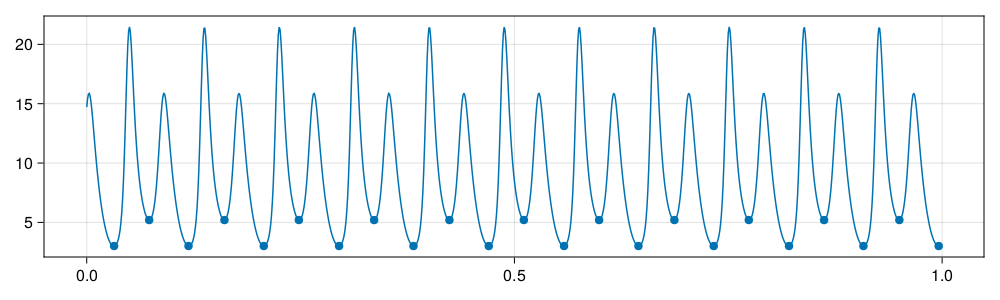

In [17]:
tstart, tend = 1, 1000
f = Figure(resolution = (1000, 300))
ax = Axis(f[1, 1])
lines!(trange[tstart:tend], tr[tstart:tend, 1])
scatter!(timemin[1:23], lcmin[1:23])
f

In [ ]:
for (idx_U0, U0) in enumerate(U0range)
    for (idx_I0, I0) in enumerate(I0range)
        
        modes[idx_I0,idx_U0] =  detect_mode(idx_I0, idx_U0)
        output(idx_U0, U0, idx_I0, I0, modes[idx_I0,idx_U0])
        separate()
        
    end
end   

index U0: 1; index I0: 1
U0: 0.3
I0: -1.4
Mode: 1.0

----------------
index U0: 1; index I0: 2
U0: 0.3
I0: -1.401545
Mode: 1.0

----------------
index U0: 1; index I0: 3
U0: 0.3
I0: -1.40309
Mode: 1.0

----------------
index U0: 1; index I0: 4
U0: 0.3
I0: -1.404635
Mode: 1.0

----------------
index U0: 1; index I0: 5
U0: 0.3
I0: -1.40618
Mode: 1.0

----------------
index U0: 1; index I0: 6
U0: 0.3
I0: -1.407725
Mode: 1.0

----------------
index U0: 1; index I0: 7
U0: 0.3
I0: -1.40927
Mode: 1.0

----------------
index U0: 1; index I0: 8
U0: 0.3
I0: -1.410815
Mode: 1.0

----------------
index U0: 1; index I0: 9
U0: 0.3
I0: -1.41236
Mode: 1.0

----------------
index U0: 1; index I0: 10
U0: 0.3
I0: -1.413905
Mode: 1.0

----------------
index U0: 1; index I0: 11
U0: 0.3
I0: -1.41545
Mode: 1.0

----------------
index U0: 1; index I0: 12
U0: 0.3
I0: -1.416995
Mode: 1.0

----------------
index U0: 1; index I0: 13
U0: 0.3
I0: -1.41854
Mode: 1.0

----------------
index U0: 1; index I0: 14
U0: 0.

Mode: 2.0

----------------
index U0: 1; index I0: 110
U0: 0.3
I0: -1.568405
Mode: 2.0

----------------
index U0: 1; index I0: 111
U0: 0.3
I0: -1.56995
Mode: 2.0

----------------
index U0: 1; index I0: 112
U0: 0.3
I0: -1.571495
Mode: 2.0

----------------
index U0: 1; index I0: 113
U0: 0.3
I0: -1.57304
Mode: 2.0

----------------
index U0: 1; index I0: 114
U0: 0.3
I0: -1.574585
Mode: 2.0

----------------
index U0: 1; index I0: 115
U0: 0.3
I0: -1.57613
Mode: 2.0

----------------
index U0: 1; index I0: 116
U0: 0.3
I0: -1.577675
Mode: 3.0

----------------
index U0: 1; index I0: 117
U0: 0.3
I0: -1.57922
Mode: 3.0

----------------
index U0: 1; index I0: 118
U0: 0.3
I0: -1.580765
Mode: 3.0

----------------
index U0: 1; index I0: 119
U0: 0.3
I0: -1.58231
Mode: 3.0

----------------
index U0: 1; index I0: 120
U0: 0.3
I0: -1.583855
Mode: 3.0

----------------
index U0: 1; index I0: 121
U0: 0.3
I0: -1.5854
Mode: 3.0

----------------
index U0: 1; index I0: 122
U0: 0.3
I0: -1.586945
Mode: 

I0: -1.42163
Mode: 1.0

----------------
index U0: 2; index I0: 16
U0: 0.30085
I0: -1.423175
Mode: 1.0

----------------
index U0: 2; index I0: 17
U0: 0.30085
I0: -1.42472
Mode: 1.0

----------------
index U0: 2; index I0: 18
U0: 0.30085
I0: -1.426265
Mode: 1.0

----------------
index U0: 2; index I0: 19
U0: 0.30085
I0: -1.42781
Mode: 1.0

----------------
index U0: 2; index I0: 20
U0: 0.30085
I0: -1.429355
Mode: 1.0

----------------
index U0: 2; index I0: 21
U0: 0.30085
I0: -1.4309
Mode: 1.0

----------------
index U0: 2; index I0: 22
U0: 0.30085
I0: -1.432445
Mode: 1.0

----------------
index U0: 2; index I0: 23
U0: 0.30085
I0: -1.43399
Mode: 1.0

----------------
index U0: 2; index I0: 24
U0: 0.30085
I0: -1.435535
Mode: 1.0

----------------
index U0: 2; index I0: 25
U0: 0.30085
I0: -1.43708
Mode: 1.0

----------------
index U0: 2; index I0: 26
U0: 0.30085
I0: -1.438625
Mode: 1.0

----------------
index U0: 2; index I0: 27
U0: 0.30085
I0: -1.44017
Mode: 1.0

----------------
index 

I0: -1.580765
Mode: 3.0

----------------
index U0: 2; index I0: 119
U0: 0.30085
I0: -1.58231
Mode: 2.0

----------------
index U0: 2; index I0: 120
U0: 0.30085
I0: -1.583855
Mode: 3.0

----------------
index U0: 2; index I0: 121
U0: 0.30085
I0: -1.5854
Mode: 3.0

----------------
index U0: 2; index I0: 122
U0: 0.30085
I0: -1.586945
Mode: 3.0

----------------
index U0: 2; index I0: 123
U0: 0.30085
I0: -1.58849
Mode: 3.0

----------------
index U0: 2; index I0: 124
U0: 0.30085
I0: -1.590035
Mode: 3.0

----------------
index U0: 2; index I0: 125
U0: 0.30085
I0: -1.59158
Mode: 3.0

----------------
index U0: 2; index I0: 126
U0: 0.30085
I0: -1.593125
Mode: 3.0

----------------
index U0: 2; index I0: 127
U0: 0.30085
I0: -1.59467
Mode: 3.0

----------------
index U0: 2; index I0: 128
U0: 0.30085
I0: -1.596215
Mode: 2.0

----------------
index U0: 2; index I0: 129
U0: 0.30085
I0: -1.59776
Mode: 3.0

----------------
index U0: 2; index I0: 130
U0: 0.30085
I0: -1.599305
Mode: 3.0

----------

index U0: 3; index I0: 20
U0: 0.3017
I0: -1.429355
Mode: 1.0

----------------
index U0: 3; index I0: 21
U0: 0.3017
I0: -1.4309
Mode: 1.0

----------------
index U0: 3; index I0: 22
U0: 0.3017
I0: -1.432445
Mode: 1.0

----------------
index U0: 3; index I0: 23
U0: 0.3017
I0: -1.43399
Mode: 1.0

----------------
index U0: 3; index I0: 24
U0: 0.3017
I0: -1.435535
Mode: 1.0

----------------
index U0: 3; index I0: 25
U0: 0.3017
I0: -1.43708
Mode: 1.0

----------------
index U0: 3; index I0: 26
U0: 0.3017
I0: -1.438625
Mode: 1.0

----------------
index U0: 3; index I0: 27
U0: 0.3017
I0: -1.44017
Mode: 1.0

----------------
index U0: 3; index I0: 28
U0: 0.3017
I0: -1.441715
Mode: 1.0

----------------
index U0: 3; index I0: 29
U0: 0.3017
I0: -1.44326
Mode: 1.0

----------------
index U0: 3; index I0: 30
U0: 0.3017
I0: -1.444805
Mode: 1.0

----------------
index U0: 3; index I0: 31
U0: 0.3017
I0: -1.44635
Mode: 1.0

----------------
index U0: 3; index I0: 32
U0: 0.3017
I0: -1.447895
Mode: 1.

U0: 0.3017
I0: -1.590035
Mode: 3.0

----------------
index U0: 3; index I0: 125
U0: 0.3017
I0: -1.59158
Mode: 3.0

----------------
index U0: 3; index I0: 126
U0: 0.3017
I0: -1.593125
Mode: 3.0

----------------
index U0: 3; index I0: 127
U0: 0.3017
I0: -1.59467
Mode: 3.0

----------------
index U0: 3; index I0: 128
U0: 0.3017
I0: -1.596215
Mode: 3.0

----------------
index U0: 3; index I0: 129
U0: 0.3017
I0: -1.59776
Mode: 3.0

----------------
index U0: 3; index I0: 130
U0: 0.3017
I0: -1.599305
Mode: 3.0

----------------
index U0: 3; index I0: 131
U0: 0.3017
I0: -1.60085
Mode: 3.0

----------------
index U0: 3; index I0: 132
U0: 0.3017
I0: -1.602395
Mode: 3.0

----------------
index U0: 3; index I0: 133
U0: 0.3017
I0: -1.60394
Mode: 3.0

----------------
index U0: 3; index I0: 134
U0: 0.3017
I0: -1.605485
Mode: 3.0

----------------
index U0: 3; index I0: 135
U0: 0.3017
I0: -1.60703
Mode: 3.0

----------------
index U0: 3; index I0: 136
U0: 0.3017
I0: -1.608575
Mode: 3.0

----------

Mode: 1.0

----------------
index U0: 4; index I0: 27
U0: 0.30255
I0: -1.44017
Mode: 1.0

----------------
index U0: 4; index I0: 28
U0: 0.30255
I0: -1.441715
Mode: 1.0

----------------
index U0: 4; index I0: 29
U0: 0.30255
I0: -1.44326
Mode: 1.0

----------------
index U0: 4; index I0: 30
U0: 0.30255
I0: -1.444805
Mode: 1.0

----------------
index U0: 4; index I0: 31
U0: 0.30255
I0: -1.44635
Mode: 1.0

----------------
index U0: 4; index I0: 32
U0: 0.30255
I0: -1.447895
Mode: 1.0

----------------
index U0: 4; index I0: 33
U0: 0.30255
I0: -1.44944
Mode: 1.0

----------------
index U0: 4; index I0: 34
U0: 0.30255
I0: -1.450985
Mode: 1.0

----------------
index U0: 4; index I0: 35
U0: 0.30255
I0: -1.45253
Mode: 1.0

----------------
index U0: 4; index I0: 36
U0: 0.30255
I0: -1.454075
Mode: 1.0

----------------
index U0: 4; index I0: 37
U0: 0.30255
I0: -1.45562
Mode: 1.0

----------------
index U0: 4; index I0: 38
U0: 0.30255
I0: -1.457165
Mode: 1.0

----------------
index U0: 4; index

I0: -1.59776
Mode: 3.0

----------------
index U0: 4; index I0: 130
U0: 0.30255
I0: -1.599305
Mode: 3.0

----------------
index U0: 4; index I0: 131
U0: 0.30255
I0: -1.60085
Mode: 3.0

----------------
index U0: 4; index I0: 132
U0: 0.30255
I0: -1.602395
Mode: 3.0

----------------
index U0: 4; index I0: 133
U0: 0.30255
I0: -1.60394
Mode: 3.0

----------------
index U0: 4; index I0: 134
U0: 0.30255
I0: -1.605485
Mode: 3.0

----------------
index U0: 4; index I0: 135
U0: 0.30255
I0: -1.60703
Mode: 3.0

----------------
index U0: 4; index I0: 136
U0: 0.30255
I0: -1.608575
Mode: 3.0

----------------
index U0: 4; index I0: 137
U0: 0.30255
I0: -1.61012
Mode: 3.0

----------------
index U0: 4; index I0: 138
U0: 0.30255
I0: -1.611665
Mode: 2.0

----------------
index U0: 4; index I0: 139
U0: 0.30255
I0: -1.61321
Mode: 2.0

----------------
index U0: 4; index I0: 140
U0: 0.30255
I0: -1.614755
Mode: 2.0

----------------
index U0: 4; index I0: 141
U0: 0.30255
I0: -1.6163
Mode: 2.0

-----------

U0: 0.3034
I0: -1.44635
Mode: 1.0

----------------
index U0: 5; index I0: 32
U0: 0.3034
I0: -1.447895
Mode: 1.0

----------------
index U0: 5; index I0: 33
U0: 0.3034
I0: -1.44944
Mode: 1.0

----------------
index U0: 5; index I0: 34
U0: 0.3034
I0: -1.450985
Mode: 1.0

----------------
index U0: 5; index I0: 35
U0: 0.3034
I0: -1.45253
Mode: 1.0

----------------
index U0: 5; index I0: 36
U0: 0.3034
I0: -1.454075
Mode: 1.0

----------------
index U0: 5; index I0: 37
U0: 0.3034
I0: -1.45562
Mode: 1.0

----------------
index U0: 5; index I0: 38
U0: 0.3034
I0: -1.457165
Mode: 1.0

----------------
index U0: 5; index I0: 39
U0: 0.3034
I0: -1.45871
Mode: 1.0

----------------
index U0: 5; index I0: 40
U0: 0.3034
I0: -1.460255
Mode: 1.0

----------------
index U0: 5; index I0: 41
U0: 0.3034
I0: -1.4618
Mode: 1.0

----------------
index U0: 5; index I0: 42
U0: 0.3034
I0: -1.463345
Mode: 1.0

----------------
index U0: 5; index I0: 43
U0: 0.3034
I0: -1.46489
Mode: 1.0

----------------
index U

U0: 0.3034
I0: -1.60703
Mode: 3.0

----------------
index U0: 5; index I0: 136
U0: 0.3034
I0: -1.608575
Mode: 3.0

----------------
index U0: 5; index I0: 137
U0: 0.3034
I0: -1.61012
Mode: 3.0

----------------
index U0: 5; index I0: 138
U0: 0.3034
I0: -1.611665
Mode: 3.0

----------------
index U0: 5; index I0: 139
U0: 0.3034
I0: -1.61321
Mode: 2.0

----------------
index U0: 5; index I0: 140
U0: 0.3034
I0: -1.614755
Mode: 2.0

----------------
index U0: 5; index I0: 141
U0: 0.3034
I0: -1.6163
Mode: 2.0

----------------
index U0: 5; index I0: 142
U0: 0.3034
I0: -1.617845
Mode: 2.0

----------------
index U0: 5; index I0: 143
U0: 0.3034
I0: -1.61939
Mode: 2.0

----------------
index U0: 5; index I0: 144
U0: 0.3034
I0: -1.620935
Mode: 2.0

----------------
index U0: 5; index I0: 145
U0: 0.3034
I0: -1.62248
Mode: 2.0

----------------
index U0: 5; index I0: 146
U0: 0.3034
I0: -1.624025
Mode: 2.0

----------------
index U0: 5; index I0: 147
U0: 0.3034
I0: -1.62557
Mode: 2.0

------------

Mode: 1.0

----------------
index U0: 6; index I0: 38
U0: 0.30425
I0: -1.457165
Mode: 1.0

----------------
index U0: 6; index I0: 39
U0: 0.30425
I0: -1.45871
Mode: 1.0

----------------
index U0: 6; index I0: 40
U0: 0.30425
I0: -1.460255
Mode: 1.0

----------------
index U0: 6; index I0: 41
U0: 0.30425
I0: -1.4618
Mode: 1.0

----------------
index U0: 6; index I0: 42
U0: 0.30425
I0: -1.463345
Mode: 1.0

----------------
index U0: 6; index I0: 43
U0: 0.30425
I0: -1.46489
Mode: 1.0

----------------
index U0: 6; index I0: 44
U0: 0.30425
I0: -1.466435
Mode: 1.0

----------------
index U0: 6; index I0: 45
U0: 0.30425
I0: -1.46798
Mode: 1.0

----------------
index U0: 6; index I0: 46
U0: 0.30425
I0: -1.469525
Mode: 1.0

----------------
index U0: 6; index I0: 47
U0: 0.30425
I0: -1.47107
Mode: 1.0

----------------
index U0: 6; index I0: 48
U0: 0.30425
I0: -1.472615
Mode: 1.0

----------------
index U0: 6; index I0: 49
U0: 0.30425
I0: -1.47416
Mode: 1.0

----------------
index U0: 6; index 

U0: 0.30425
I0: -1.614755
Mode: 2.0

----------------
index U0: 6; index I0: 141
U0: 0.30425
I0: -1.6163
Mode: 2.0

----------------
index U0: 6; index I0: 142
U0: 0.30425
I0: -1.617845
Mode: 2.0

----------------
index U0: 6; index I0: 143
U0: 0.30425
I0: -1.61939
Mode: 2.0

----------------
index U0: 6; index I0: 144
U0: 0.30425
I0: -1.620935
Mode: 2.0

----------------
index U0: 6; index I0: 145
U0: 0.30425
I0: -1.62248
Mode: 2.0

----------------
index U0: 6; index I0: 146
U0: 0.30425
I0: -1.624025
Mode: 2.0

----------------
index U0: 6; index I0: 147
U0: 0.30425
I0: -1.62557
Mode: 2.0

----------------
index U0: 6; index I0: 148
U0: 0.30425
I0: -1.627115
Mode: 2.0

----------------
index U0: 6; index I0: 149
U0: 0.30425
I0: -1.62866
Mode: 2.0

----------------
index U0: 6; index I0: 150
U0: 0.30425
I0: -1.630205
Mode: 2.0

----------------
index U0: 6; index I0: 151
U0: 0.30425
I0: -1.63175
Mode: 2.0

----------------
index U0: 6; index I0: 152
U0: 0.30425
I0: -1.633295
Mode: 2.0

I0: -1.463345
Mode: 1.0

----------------
index U0: 7; index I0: 43
U0: 0.3051
I0: -1.46489
Mode: 1.0

----------------
index U0: 7; index I0: 44
U0: 0.3051
I0: -1.466435
Mode: 1.0

----------------
index U0: 7; index I0: 45
U0: 0.3051
I0: -1.46798
Mode: 1.0

----------------
index U0: 7; index I0: 46
U0: 0.3051
I0: -1.469525
Mode: 1.0

----------------
index U0: 7; index I0: 47
U0: 0.3051
I0: -1.47107
Mode: 1.0

----------------
index U0: 7; index I0: 48
U0: 0.3051
I0: -1.472615
Mode: 1.0

----------------
index U0: 7; index I0: 49
U0: 0.3051
I0: -1.47416
Mode: 1.0

----------------
index U0: 7; index I0: 50
U0: 0.3051
I0: -1.475705
Mode: 1.0

----------------
index U0: 7; index I0: 51
U0: 0.3051
I0: -1.47725
Mode: 1.0

----------------
index U0: 7; index I0: 52
U0: 0.3051
I0: -1.478795
Mode: 1.0

----------------
index U0: 7; index I0: 53
U0: 0.3051
I0: -1.48034
Mode: 1.0

----------------
index U0: 7; index I0: 54
U0: 0.3051
I0: -1.481885
Mode: 1.0

----------------
index U0: 7; ind

U0: 0.3051
I0: -1.624025
Mode: 2.0

----------------
index U0: 7; index I0: 147
U0: 0.3051
I0: -1.62557
Mode: 2.0

----------------
index U0: 7; index I0: 148
U0: 0.3051
I0: -1.627115
Mode: 2.0

----------------
index U0: 7; index I0: 149
U0: 0.3051
I0: -1.62866
Mode: 2.0

----------------
index U0: 7; index I0: 150
U0: 0.3051
I0: -1.630205
Mode: 2.0

----------------
index U0: 7; index I0: 151
U0: 0.3051
I0: -1.63175
Mode: 2.0

----------------
index U0: 7; index I0: 152
U0: 0.3051
I0: -1.633295
Mode: 2.0

----------------
index U0: 7; index I0: 153
U0: 0.3051
I0: -1.63484
Mode: 2.0

----------------
index U0: 7; index I0: 154
U0: 0.3051
I0: -1.636385
Mode: 2.0

----------------
index U0: 7; index I0: 155
U0: 0.3051
I0: -1.63793
Mode: 2.0

----------------
index U0: 7; index I0: 156
U0: 0.3051
I0: -1.639475
Mode: 2.0

----------------
index U0: 7; index I0: 157
U0: 0.3051
I0: -1.64102
Mode: 2.0

----------------
index U0: 7; index I0: 158
U0: 0.3051
I0: -1.642565
Mode: 2.0

----------

Mode: 1.0

----------------
index U0: 8; index I0: 49
U0: 0.30595
I0: -1.47416
Mode: 1.0

----------------
index U0: 8; index I0: 50
U0: 0.30595
I0: -1.475705
Mode: 1.0

----------------
index U0: 8; index I0: 51
U0: 0.30595
I0: -1.47725
Mode: 1.0

----------------
index U0: 8; index I0: 52
U0: 0.30595
I0: -1.478795
Mode: 1.0

----------------
index U0: 8; index I0: 53
U0: 0.30595
I0: -1.48034
Mode: 1.0

----------------
index U0: 8; index I0: 54
U0: 0.30595
I0: -1.481885
Mode: 1.0

----------------
index U0: 8; index I0: 55
U0: 0.30595
I0: -1.48343
Mode: 1.0

----------------
index U0: 8; index I0: 56
U0: 0.30595
I0: -1.484975
Mode: 1.0

----------------
index U0: 8; index I0: 57
U0: 0.30595
I0: -1.48652
Mode: 1.0

----------------
index U0: 8; index I0: 58
U0: 0.30595
I0: -1.488065
Mode: 1.0

----------------
index U0: 8; index I0: 59
U0: 0.30595
I0: -1.48961
Mode: 1.0

----------------
index U0: 8; index I0: 60
U0: 0.30595
I0: -1.491155
Mode: 1.0

----------------
index U0: 8; index

U0: 0.30595
I0: -1.63175
Mode: 2.0

----------------
index U0: 8; index I0: 152
U0: 0.30595
I0: -1.633295
Mode: 2.0

----------------
index U0: 8; index I0: 153
U0: 0.30595
I0: -1.63484
Mode: 2.0

----------------
index U0: 8; index I0: 154
U0: 0.30595
I0: -1.636385
Mode: 2.0

----------------
index U0: 8; index I0: 155
U0: 0.30595
I0: -1.63793
Mode: 2.0

----------------
index U0: 8; index I0: 156
U0: 0.30595
I0: -1.639475
Mode: 2.0

----------------
index U0: 8; index I0: 157
U0: 0.30595
I0: -1.64102
Mode: 2.0

----------------
index U0: 8; index I0: 158
U0: 0.30595
I0: -1.642565
Mode: 2.0

----------------
index U0: 8; index I0: 159
U0: 0.30595
I0: -1.64411
Mode: 2.0

----------------
index U0: 8; index I0: 160
U0: 0.30595
I0: -1.645655
Mode: 2.0

----------------
index U0: 8; index I0: 161
U0: 0.30595
I0: -1.6472
Mode: 2.0

----------------
index U0: 8; index I0: 162
U0: 0.30595
I0: -1.648745
Mode: 2.0

----------------
index U0: 8; index I0: 163
U0: 0.30595
I0: -1.65029
Mode: 2.0



----------------
index U0: 9; index I0: 54
U0: 0.3068
I0: -1.481885
Mode: 1.0

----------------
index U0: 9; index I0: 55
U0: 0.3068
I0: -1.48343
Mode: 1.0

----------------
index U0: 9; index I0: 56
U0: 0.3068
I0: -1.484975
Mode: 1.0

----------------
index U0: 9; index I0: 57
U0: 0.3068
I0: -1.48652
Mode: 1.0

----------------
index U0: 9; index I0: 58
U0: 0.3068
I0: -1.488065
Mode: 1.0

----------------
index U0: 9; index I0: 59
U0: 0.3068
I0: -1.48961
Mode: 1.0

----------------
index U0: 9; index I0: 60
U0: 0.3068
I0: -1.491155
Mode: 1.0

----------------
index U0: 9; index I0: 61
U0: 0.3068
I0: -1.4927
Mode: 1.0

----------------
index U0: 9; index I0: 62
U0: 0.3068
I0: -1.494245
Mode: 1.0

----------------
index U0: 9; index I0: 63
U0: 0.3068
I0: -1.49579
Mode: 1.0

----------------
index U0: 9; index I0: 64
U0: 0.3068
I0: -1.497335
Mode: 1.0

----------------
index U0: 9; index I0: 65
U0: 0.3068
I0: -1.49888
Mode: 1.0

----------------
index U0: 9; index I0: 66
U0: 0.3068
I0: 

I0: -1.64102
Mode: 2.0

----------------
index U0: 9; index I0: 158
U0: 0.3068
I0: -1.642565
Mode: 2.0

----------------
index U0: 9; index I0: 159
U0: 0.3068
I0: -1.64411
Mode: 2.0

----------------
index U0: 9; index I0: 160
U0: 0.3068
I0: -1.645655
Mode: 2.0

----------------
index U0: 9; index I0: 161
U0: 0.3068
I0: -1.6472
Mode: 2.0

----------------
index U0: 9; index I0: 162
U0: 0.3068
I0: -1.648745
Mode: 2.0

----------------
index U0: 9; index I0: 163
U0: 0.3068
I0: -1.65029
Mode: 2.0

----------------
index U0: 9; index I0: 164
U0: 0.3068
I0: -1.651835
Mode: 2.0

----------------
index U0: 9; index I0: 165
U0: 0.3068
I0: -1.65338
Mode: 2.0

----------------
index U0: 9; index I0: 166
U0: 0.3068
I0: -1.654925
Mode: 2.0

----------------
index U0: 9; index I0: 167
U0: 0.3068
I0: -1.65647
Mode: 2.0

----------------
index U0: 9; index I0: 168
U0: 0.3068
I0: -1.658015
Mode: 2.0

----------------
index U0: 9; index I0: 169
U0: 0.3068
I0: -1.65956
Mode: 2.0

----------------
index 

U0: 0.30765
I0: -1.48961
Mode: 1.0

----------------
index U0: 10; index I0: 60
U0: 0.30765
I0: -1.491155
Mode: 1.0

----------------
index U0: 10; index I0: 61
U0: 0.30765
I0: -1.4927
Mode: 1.0

----------------
index U0: 10; index I0: 62
U0: 0.30765
I0: -1.494245
Mode: 1.0

----------------
index U0: 10; index I0: 63
U0: 0.30765
I0: -1.49579
Mode: 1.0

----------------
index U0: 10; index I0: 64
U0: 0.30765
I0: -1.497335
Mode: 1.0

----------------
index U0: 10; index I0: 65
U0: 0.30765
I0: -1.49888
Mode: 1.0

----------------
index U0: 10; index I0: 66
U0: 0.30765
I0: -1.500425
Mode: 1.0

----------------
index U0: 10; index I0: 67
U0: 0.30765
I0: -1.50197
Mode: 1.0

----------------
index U0: 10; index I0: 68
U0: 0.30765
I0: -1.503515
Mode: 1.0

----------------
index U0: 10; index I0: 69
U0: 0.30765
I0: -1.50506
Mode: 1.0

----------------
index U0: 10; index I0: 70
U0: 0.30765
I0: -1.506605
Mode: 1.0

----------------
index U0: 10; index I0: 71
U0: 0.30765
I0: -1.50815
Mode: 1.0


I0: -1.645655
Mode: 2.0

----------------
index U0: 10; index I0: 161
U0: 0.30765
I0: -1.6472
Mode: 2.0

----------------
index U0: 10; index I0: 162
U0: 0.30765
I0: -1.648745
Mode: 2.0

----------------
index U0: 10; index I0: 163
U0: 0.30765
I0: -1.65029
Mode: 2.0

----------------
index U0: 10; index I0: 164
U0: 0.30765
I0: -1.651835
Mode: 2.0

----------------
index U0: 10; index I0: 165
U0: 0.30765
I0: -1.65338
Mode: 2.0

----------------
index U0: 10; index I0: 166
U0: 0.30765
I0: -1.654925
Mode: 2.0

----------------
index U0: 10; index I0: 167
U0: 0.30765
I0: -1.65647
Mode: 2.0

----------------
index U0: 10; index I0: 168
U0: 0.30765
I0: -1.658015
Mode: 2.0

----------------
index U0: 10; index I0: 169
U0: 0.30765
I0: -1.65956
Mode: 2.0

----------------
index U0: 10; index I0: 170
U0: 0.30765
I0: -1.661105
Mode: 2.0

----------------
index U0: 10; index I0: 171
U0: 0.30765
I0: -1.66265
Mode: 2.0

----------------
index U0: 10; index I0: 172
U0: 0.30765
I0: -1.664195
Mode: 2.0


----------------
index U0: 11; index I0: 62
U0: 0.3085
I0: -1.494245
Mode: 1.0

----------------
index U0: 11; index I0: 63
U0: 0.3085
I0: -1.49579
Mode: 1.0

----------------
index U0: 11; index I0: 64
U0: 0.3085
I0: -1.497335
Mode: 1.0

----------------
index U0: 11; index I0: 65
U0: 0.3085
I0: -1.49888
Mode: 1.0

----------------
index U0: 11; index I0: 66
U0: 0.3085
I0: -1.500425
Mode: 1.0

----------------
index U0: 11; index I0: 67
U0: 0.3085
I0: -1.50197
Mode: 1.0

----------------
index U0: 11; index I0: 68
U0: 0.3085
I0: -1.503515
Mode: 1.0

----------------
index U0: 11; index I0: 69
U0: 0.3085
I0: -1.50506
Mode: 1.0

----------------
index U0: 11; index I0: 70
U0: 0.3085
I0: -1.506605
Mode: 1.0

----------------
index U0: 11; index I0: 71
U0: 0.3085
I0: -1.50815
Mode: 1.0

----------------
index U0: 11; index I0: 72
U0: 0.3085
I0: -1.509695
Mode: 1.0

----------------
index U0: 11; index I0: 73
U0: 0.3085
I0: -1.51124
Mode: 1.0

----------------
index U0: 11; index I0: 74
U

U0: 0.3085
I0: -1.651835
Mode: 2.0

----------------
index U0: 11; index I0: 165
U0: 0.3085
I0: -1.65338
Mode: 2.0

----------------
index U0: 11; index I0: 166
U0: 0.3085
I0: -1.654925
Mode: 2.0

----------------
index U0: 11; index I0: 167
U0: 0.3085
I0: -1.65647
Mode: 2.0

----------------
index U0: 11; index I0: 168
U0: 0.3085
I0: -1.658015
Mode: 2.0

----------------
index U0: 11; index I0: 169
U0: 0.3085
I0: -1.65956
Mode: 2.0

----------------
index U0: 11; index I0: 170
U0: 0.3085
I0: -1.661105
Mode: 2.0

----------------
index U0: 11; index I0: 171
U0: 0.3085
I0: -1.66265
Mode: 2.0

----------------
index U0: 11; index I0: 172
U0: 0.3085
I0: -1.664195
Mode: 2.0

----------------
index U0: 11; index I0: 173
U0: 0.3085
I0: -1.66574
Mode: 2.0

----------------
index U0: 11; index I0: 174
U0: 0.3085
I0: -1.667285
Mode: 2.0

----------------
index U0: 11; index I0: 175
U0: 0.3085
I0: -1.66883
Mode: 2.0

----------------
index U0: 11; index I0: 176
U0: 0.3085
I0: -1.670375
Mode: 2.0

I0: -1.49888
Mode: 1.0

----------------
index U0: 12; index I0: 66
U0: 0.30935
I0: -1.500425
Mode: 1.0

----------------
index U0: 12; index I0: 67
U0: 0.30935
I0: -1.50197
Mode: 1.0

----------------
index U0: 12; index I0: 68
U0: 0.30935
I0: -1.503515
Mode: 1.0

----------------
index U0: 12; index I0: 69
U0: 0.30935
I0: -1.50506
Mode: 1.0

----------------
index U0: 12; index I0: 70
U0: 0.30935
I0: -1.506605
Mode: 1.0

----------------
index U0: 12; index I0: 71
U0: 0.30935
I0: -1.50815
Mode: 1.0

----------------
index U0: 12; index I0: 72
U0: 0.30935
I0: -1.509695
Mode: 1.0

----------------
index U0: 12; index I0: 73
U0: 0.30935
I0: -1.51124
Mode: 1.0

----------------
index U0: 12; index I0: 74
U0: 0.30935
I0: -1.512785
Mode: 1.0

----------------
index U0: 12; index I0: 75
U0: 0.30935
I0: -1.51433
Mode: 1.0

----------------
index U0: 12; index I0: 76
U0: 0.30935
I0: -1.515875
Mode: 2.0

----------------
index U0: 12; index I0: 77
U0: 0.30935
I0: -1.51742
Mode: 2.0

----------

Mode: 2.0

----------------
index U0: 12; index I0: 167
U0: 0.30935
I0: -1.65647
Mode: 2.0

----------------
index U0: 12; index I0: 168
U0: 0.30935
I0: -1.658015
Mode: 2.0

----------------
index U0: 12; index I0: 169
U0: 0.30935
I0: -1.65956
Mode: 2.0

----------------
index U0: 12; index I0: 170
U0: 0.30935
I0: -1.661105
Mode: 2.0

----------------
index U0: 12; index I0: 171
U0: 0.30935
I0: -1.66265
Mode: 2.0

----------------
index U0: 12; index I0: 172
U0: 0.30935
I0: -1.664195
Mode: 2.0

----------------
index U0: 12; index I0: 173
U0: 0.30935
I0: -1.66574
Mode: 2.0

----------------
index U0: 12; index I0: 174
U0: 0.30935
I0: -1.667285
Mode: 2.0

----------------
index U0: 12; index I0: 175
U0: 0.30935
I0: -1.66883
Mode: 2.0

----------------
index U0: 12; index I0: 176
U0: 0.30935
I0: -1.670375
Mode: 2.0

----------------
index U0: 12; index I0: 177
U0: 0.30935
I0: -1.67192
Mode: 2.0

----------------
index U0: 12; index I0: 178
U0: 0.30935
I0: -1.673465
Mode: 2.0

-----------

U0: 0.3102
I0: -1.503515
Mode: 1.0

----------------
index U0: 13; index I0: 69
U0: 0.3102
I0: -1.50506
Mode: 1.0

----------------
index U0: 13; index I0: 70
U0: 0.3102
I0: -1.506605
Mode: 1.0

----------------
index U0: 13; index I0: 71
U0: 0.3102
I0: -1.50815
Mode: 1.0

----------------
index U0: 13; index I0: 72
U0: 0.3102
I0: -1.509695
Mode: 1.0

----------------
index U0: 13; index I0: 73
U0: 0.3102
I0: -1.51124
Mode: 1.0

----------------
index U0: 13; index I0: 74
U0: 0.3102
I0: -1.512785
Mode: 1.0

----------------
index U0: 13; index I0: 75
U0: 0.3102
I0: -1.51433
Mode: 2.0

----------------
index U0: 13; index I0: 76
U0: 0.3102
I0: -1.515875
Mode: 2.0

----------------
index U0: 13; index I0: 77
U0: 0.3102
I0: -1.51742
Mode: 2.0

----------------
index U0: 13; index I0: 78
U0: 0.3102
I0: -1.518965
Mode: 2.0

----------------
index U0: 13; index I0: 79
U0: 0.3102
I0: -1.52051
Mode: 2.0

----------------
index U0: 13; index I0: 80
U0: 0.3102
I0: -1.522055
Mode: 2.0

----------

Mode: 2.0

----------------
index U0: 13; index I0: 171
U0: 0.3102
I0: -1.66265
Mode: 2.0

----------------
index U0: 13; index I0: 172
U0: 0.3102
I0: -1.664195
Mode: 2.0

----------------
index U0: 13; index I0: 173
U0: 0.3102
I0: -1.66574
Mode: 2.0

----------------
index U0: 13; index I0: 174
U0: 0.3102
I0: -1.667285
Mode: 2.0

----------------
index U0: 13; index I0: 175
U0: 0.3102
I0: -1.66883
Mode: 2.0

----------------
index U0: 13; index I0: 176
U0: 0.3102
I0: -1.670375
Mode: 2.0

----------------
index U0: 13; index I0: 177
U0: 0.3102
I0: -1.67192
Mode: 2.0

----------------
index U0: 13; index I0: 178
U0: 0.3102
I0: -1.673465
Mode: 2.0

----------------
index U0: 13; index I0: 179
U0: 0.3102
I0: -1.67501
Mode: 2.0

----------------
index U0: 13; index I0: 180
U0: 0.3102
I0: -1.676555
Mode: 2.0

----------------
index U0: 13; index I0: 181
U0: 0.3102
I0: -1.6781
Mode: 2.0

----------------
index U0: 13; index I0: 182
U0: 0.3102
I0: -1.679645
Mode: 2.0

----------------
index U


----------------
index U0: 14; index I0: 72
U0: 0.31105
I0: -1.509695
Mode: 1.0

----------------
index U0: 14; index I0: 73
U0: 0.31105
I0: -1.51124
Mode: 1.0

----------------
index U0: 14; index I0: 74
U0: 0.31105
I0: -1.512785
Mode: 1.0

----------------
index U0: 14; index I0: 75
U0: 0.31105
I0: -1.51433
Mode: 2.0

----------------
index U0: 14; index I0: 76
U0: 0.31105
I0: -1.515875
Mode: 2.0

----------------
index U0: 14; index I0: 77
U0: 0.31105
I0: -1.51742
Mode: 2.0

----------------
index U0: 14; index I0: 78
U0: 0.31105
I0: -1.518965
Mode: 2.0

----------------
index U0: 14; index I0: 79
U0: 0.31105
I0: -1.52051
Mode: 2.0

----------------
index U0: 14; index I0: 80
U0: 0.31105
I0: -1.522055
Mode: 2.0

----------------
index U0: 14; index I0: 81
U0: 0.31105
I0: -1.5236
Mode: 2.0

----------------
index U0: 14; index I0: 82
U0: 0.31105
I0: -1.525145
Mode: 2.0

----------------
index U0: 14; index I0: 83
U0: 0.31105
I0: -1.52669
Mode: 2.0

----------------
index U0: 14; ind


----------------
index U0: 14; index I0: 173
U0: 0.31105
I0: -1.66574
Mode: 2.0

----------------
index U0: 14; index I0: 174
U0: 0.31105
I0: -1.667285
Mode: 2.0

----------------
index U0: 14; index I0: 175
U0: 0.31105
I0: -1.66883
Mode: 2.0

----------------
index U0: 14; index I0: 176
U0: 0.31105
I0: -1.670375
Mode: 2.0

----------------
index U0: 14; index I0: 177
U0: 0.31105
I0: -1.67192
Mode: 2.0

----------------
index U0: 14; index I0: 178
U0: 0.31105
I0: -1.673465
Mode: 2.0

----------------
index U0: 14; index I0: 179
U0: 0.31105
I0: -1.67501
Mode: 2.0

----------------
index U0: 14; index I0: 180
U0: 0.31105
I0: -1.676555
Mode: 2.0

----------------
index U0: 14; index I0: 181
U0: 0.31105
I0: -1.6781
Mode: 2.0

----------------
index U0: 14; index I0: 182
U0: 0.31105
I0: -1.679645
Mode: 2.0

----------------
index U0: 14; index I0: 183
U0: 0.31105
I0: -1.68119
Mode: 2.0

----------------
index U0: 14; index I0: 184
U0: 0.31105
I0: -1.682735
Mode: 2.0

----------------
index

I0: -1.512785
Mode: 2.0

----------------
index U0: 15; index I0: 75
U0: 0.3119
I0: -1.51433
Mode: 2.0

----------------
index U0: 15; index I0: 76
U0: 0.3119
I0: -1.515875
Mode: 2.0

----------------
index U0: 15; index I0: 77
U0: 0.3119
I0: -1.51742
Mode: 2.0

----------------
index U0: 15; index I0: 78
U0: 0.3119
I0: -1.518965
Mode: 2.0

----------------
index U0: 15; index I0: 79
U0: 0.3119
I0: -1.52051
Mode: 2.0

----------------
index U0: 15; index I0: 80
U0: 0.3119
I0: -1.522055
Mode: 2.0

----------------
index U0: 15; index I0: 81
U0: 0.3119
I0: -1.5236
Mode: 2.0

----------------
index U0: 15; index I0: 82
U0: 0.3119
I0: -1.525145
Mode: 2.0

----------------
index U0: 15; index I0: 83
U0: 0.3119
I0: -1.52669
Mode: 2.0

----------------
index U0: 15; index I0: 84
U0: 0.3119
I0: -1.528235
Mode: 2.0

----------------
index U0: 15; index I0: 85
U0: 0.3119
I0: -1.52978
Mode: 2.0

----------------
index U0: 15; index I0: 86
U0: 0.3119
I0: -1.531325
Mode: 2.0

----------------
index

Mode: 2.0

----------------
index U0: 15; index I0: 177
U0: 0.3119
I0: -1.67192
Mode: 2.0

----------------
index U0: 15; index I0: 178
U0: 0.3119
I0: -1.673465
Mode: 2.0

----------------
index U0: 15; index I0: 179
U0: 0.3119
I0: -1.67501
Mode: 2.0

----------------
index U0: 15; index I0: 180
U0: 0.3119
I0: -1.676555
Mode: 2.0

----------------
index U0: 15; index I0: 181
U0: 0.3119
I0: -1.6781
Mode: 2.0

----------------
index U0: 15; index I0: 182
U0: 0.3119
I0: -1.679645
Mode: 2.0

----------------
index U0: 15; index I0: 183
U0: 0.3119
I0: -1.68119
Mode: 2.0

----------------
index U0: 15; index I0: 184
U0: 0.3119
I0: -1.682735
Mode: 2.0

----------------
index U0: 15; index I0: 185
U0: 0.3119
I0: -1.68428
Mode: 2.0

----------------
index U0: 15; index I0: 186
U0: 0.3119
I0: -1.685825
Mode: 2.0

----------------
index U0: 15; index I0: 187
U0: 0.3119
I0: -1.68737
Mode: 2.0

----------------
index U0: 15; index I0: 188
U0: 0.3119
I0: -1.688915
Mode: 2.0

----------------
index U


----------------
index U0: 16; index I0: 78
U0: 0.31275
I0: -1.518965
Mode: 2.0

----------------
index U0: 16; index I0: 79
U0: 0.31275
I0: -1.52051
Mode: 2.0

----------------
index U0: 16; index I0: 80
U0: 0.31275
I0: -1.522055
Mode: 2.0

----------------
index U0: 16; index I0: 81
U0: 0.31275
I0: -1.5236
Mode: 2.0

----------------
index U0: 16; index I0: 82
U0: 0.31275
I0: -1.525145
Mode: 2.0

----------------
index U0: 16; index I0: 83
U0: 0.31275
I0: -1.52669
Mode: 2.0

----------------
index U0: 16; index I0: 84
U0: 0.31275
I0: -1.528235
Mode: 2.0

----------------
index U0: 16; index I0: 85
U0: 0.31275
I0: -1.52978
Mode: 2.0

----------------
index U0: 16; index I0: 86
U0: 0.31275
I0: -1.531325
Mode: 2.0

----------------
index U0: 16; index I0: 87
U0: 0.31275
I0: -1.53287
Mode: 2.0

----------------
index U0: 16; index I0: 88
U0: 0.31275
I0: -1.534415
Mode: 2.0

----------------
index U0: 16; index I0: 89
U0: 0.31275
I0: -1.53596
Mode: 2.0

----------------
index U0: 16; ind

Mode: 2.0

----------------
index U0: 16; index I0: 179
U0: 0.31275
I0: -1.67501
Mode: 2.0

----------------
index U0: 16; index I0: 180
U0: 0.31275
I0: -1.676555
Mode: 2.0

----------------
index U0: 16; index I0: 181
U0: 0.31275
I0: -1.6781
Mode: 2.0

----------------
index U0: 16; index I0: 182
U0: 0.31275
I0: -1.679645
Mode: 2.0

----------------
index U0: 16; index I0: 183
U0: 0.31275
I0: -1.68119
Mode: 2.0

----------------
index U0: 16; index I0: 184
U0: 0.31275
I0: -1.682735
Mode: 2.0

----------------
index U0: 16; index I0: 185
U0: 0.31275
I0: -1.68428
Mode: 2.0

----------------
index U0: 16; index I0: 186
U0: 0.31275
I0: -1.685825
Mode: 2.0

----------------
index U0: 16; index I0: 187
U0: 0.31275
I0: -1.68737
Mode: 2.0

----------------
index U0: 16; index I0: 188
U0: 0.31275
I0: -1.688915
Mode: 2.0

----------------
index U0: 16; index I0: 189
U0: 0.31275
I0: -1.69046
Mode: 2.0

----------------
index U0: 16; index I0: 190
U0: 0.31275
I0: -1.692005
Mode: 2.0

------------

I0: -1.522055
Mode: 2.0

----------------
index U0: 17; index I0: 81
U0: 0.3136
I0: -1.5236
Mode: 2.0

----------------
index U0: 17; index I0: 82
U0: 0.3136
I0: -1.525145
Mode: 2.0

----------------
index U0: 17; index I0: 83
U0: 0.3136
I0: -1.52669
Mode: 2.0

----------------
index U0: 17; index I0: 84
U0: 0.3136
I0: -1.528235
Mode: 2.0

----------------
index U0: 17; index I0: 85
U0: 0.3136
I0: -1.52978
Mode: 2.0

----------------
index U0: 17; index I0: 86
U0: 0.3136
I0: -1.531325
Mode: 2.0

----------------
index U0: 17; index I0: 87
U0: 0.3136
I0: -1.53287
Mode: 2.0

----------------
index U0: 17; index I0: 88
U0: 0.3136
I0: -1.534415
Mode: 2.0

----------------
index U0: 17; index I0: 89
U0: 0.3136
I0: -1.53596
Mode: 2.0

----------------
index U0: 17; index I0: 90
U0: 0.3136
I0: -1.537505
Mode: 2.0

----------------
index U0: 17; index I0: 91
U0: 0.3136
I0: -1.53905
Mode: 2.0

----------------
index U0: 17; index I0: 92
U0: 0.3136
I0: -1.540595
Mode: 2.0

----------------
index

Mode: 2.0

----------------
index U0: 17; index I0: 183
U0: 0.3136
I0: -1.68119
Mode: 2.0

----------------
index U0: 17; index I0: 184
U0: 0.3136
I0: -1.682735
Mode: 2.0

----------------
index U0: 17; index I0: 185
U0: 0.3136
I0: -1.68428
Mode: 2.0

----------------
index U0: 17; index I0: 186
U0: 0.3136
I0: -1.685825
Mode: 2.0

----------------
index U0: 17; index I0: 187
U0: 0.3136
I0: -1.68737
Mode: 2.0

----------------
index U0: 17; index I0: 188
U0: 0.3136
I0: -1.688915
Mode: 2.0

----------------
index U0: 17; index I0: 189
U0: 0.3136
I0: -1.69046
Mode: 2.0

----------------
index U0: 17; index I0: 190
U0: 0.3136
I0: -1.692005
Mode: 2.0

----------------
index U0: 17; index I0: 191
U0: 0.3136
I0: -1.69355
Mode: 2.0

----------------
index U0: 17; index I0: 192
U0: 0.3136
I0: -1.695095
Mode: 2.0

----------------
index U0: 17; index I0: 193
U0: 0.3136
I0: -1.69664
Mode: 2.0

----------------
index U0: 17; index I0: 194
U0: 0.3136
I0: -1.698185
Mode: 2.0

----------------
index 


----------------
index U0: 18; index I0: 84
U0: 0.31445
I0: -1.528235
Mode: 2.0

----------------
index U0: 18; index I0: 85
U0: 0.31445
I0: -1.52978
Mode: 2.0

----------------
index U0: 18; index I0: 86
U0: 0.31445
I0: -1.531325
Mode: 2.0

----------------
index U0: 18; index I0: 87
U0: 0.31445
I0: -1.53287
Mode: 2.0

----------------
index U0: 18; index I0: 88
U0: 0.31445
I0: -1.534415
Mode: 2.0

----------------
index U0: 18; index I0: 89
U0: 0.31445
I0: -1.53596
Mode: 2.0

----------------
index U0: 18; index I0: 90
U0: 0.31445
I0: -1.537505
Mode: 2.0

----------------
index U0: 18; index I0: 91
U0: 0.31445
I0: -1.53905
Mode: 2.0

----------------
index U0: 18; index I0: 92
U0: 0.31445
I0: -1.540595
Mode: 2.0

----------------
index U0: 18; index I0: 93
U0: 0.31445
I0: -1.54214
Mode: 2.0

----------------
index U0: 18; index I0: 94
U0: 0.31445
I0: -1.543685
Mode: 2.0

----------------
index U0: 18; index I0: 95
U0: 0.31445
I0: -1.54523
Mode: 2.0

----------------
index U0: 18; in

Mode: 2.0

----------------
index U0: 18; index I0: 185
U0: 0.31445
I0: -1.68428
Mode: 2.0

----------------
index U0: 18; index I0: 186
U0: 0.31445
I0: -1.685825
Mode: 2.0

----------------
index U0: 18; index I0: 187
U0: 0.31445
I0: -1.68737
Mode: 2.0

----------------
index U0: 18; index I0: 188
U0: 0.31445
I0: -1.688915
Mode: 2.0

----------------
index U0: 18; index I0: 189
U0: 0.31445
I0: -1.69046
Mode: 2.0

----------------
index U0: 18; index I0: 190
U0: 0.31445
I0: -1.692005
Mode: 2.0

----------------
index U0: 18; index I0: 191
U0: 0.31445
I0: -1.69355
Mode: 2.0

----------------
index U0: 18; index I0: 192
U0: 0.31445
I0: -1.695095
Mode: 2.0

----------------
index U0: 18; index I0: 193
U0: 0.31445
I0: -1.69664
Mode: 2.0

----------------
index U0: 18; index I0: 194
U0: 0.31445
I0: -1.698185
Mode: 2.0

----------------
index U0: 18; index I0: 195
U0: 0.31445
I0: -1.69973
Mode: 2.0

----------------
index U0: 18; index I0: 196
U0: 0.31445
I0: -1.701275
Mode: 2.0

-----------

Mode: 2.0

----------------
index U0: 19; index I0: 87
U0: 0.3153
I0: -1.53287
Mode: 2.0

----------------
index U0: 19; index I0: 88
U0: 0.3153
I0: -1.534415
Mode: 2.0

----------------
index U0: 19; index I0: 89
U0: 0.3153
I0: -1.53596
Mode: 2.0

----------------
index U0: 19; index I0: 90
U0: 0.3153
I0: -1.537505
Mode: 2.0

----------------
index U0: 19; index I0: 91
U0: 0.3153
I0: -1.53905
Mode: 2.0

----------------
index U0: 19; index I0: 92
U0: 0.3153
I0: -1.540595
Mode: 2.0

----------------
index U0: 19; index I0: 93
U0: 0.3153
I0: -1.54214
Mode: 2.0

----------------
index U0: 19; index I0: 94
U0: 0.3153
I0: -1.543685
Mode: 2.0

----------------
index U0: 19; index I0: 95
U0: 0.3153
I0: -1.54523
Mode: 2.0

----------------
index U0: 19; index I0: 96
U0: 0.3153
I0: -1.546775
Mode: 2.0

----------------
index U0: 19; index I0: 97
U0: 0.3153
I0: -1.54832
Mode: 2.0

----------------
index U0: 19; index I0: 98
U0: 0.3153
I0: -1.549865
Mode: 2.0

----------------
index U0: 19; inde

Mode: 2.0

----------------
index U0: 19; index I0: 189
U0: 0.3153
I0: -1.69046
Mode: 2.0

----------------
index U0: 19; index I0: 190
U0: 0.3153
I0: -1.692005
Mode: 2.0

----------------
index U0: 19; index I0: 191
U0: 0.3153
I0: -1.69355
Mode: 2.0

----------------
index U0: 19; index I0: 192
U0: 0.3153
I0: -1.695095
Mode: 2.0

----------------
index U0: 19; index I0: 193
U0: 0.3153
I0: -1.69664
Mode: 2.0

----------------
index U0: 19; index I0: 194
U0: 0.3153
I0: -1.698185
Mode: 2.0

----------------
index U0: 19; index I0: 195
U0: 0.3153
I0: -1.69973
Mode: 2.0

----------------
index U0: 19; index I0: 196
U0: 0.3153
I0: -1.701275
Mode: 2.0

----------------
index U0: 19; index I0: 197
U0: 0.3153
I0: -1.70282
Mode: 2.0

----------------
index U0: 19; index I0: 198
U0: 0.3153
I0: -1.704365
Mode: 2.0

----------------
index U0: 19; index I0: 199
U0: 0.3153
I0: -1.70591
Mode: 2.0

----------------
index U0: 19; index I0: 200
U0: 0.3153
I0: -1.707455
Mode: 2.0

----------------
index 


----------------
index U0: 20; index I0: 90
U0: 0.31615
I0: -1.537505
Mode: 2.0

----------------
index U0: 20; index I0: 91
U0: 0.31615
I0: -1.53905
Mode: 2.0

----------------
index U0: 20; index I0: 92
U0: 0.31615
I0: -1.540595
Mode: 2.0

----------------
index U0: 20; index I0: 93
U0: 0.31615
I0: -1.54214
Mode: 2.0

----------------
index U0: 20; index I0: 94
U0: 0.31615
I0: -1.543685
Mode: 2.0

----------------
index U0: 20; index I0: 95
U0: 0.31615
I0: -1.54523
Mode: 2.0

----------------
index U0: 20; index I0: 96
U0: 0.31615
I0: -1.546775
Mode: 2.0

----------------
index U0: 20; index I0: 97
U0: 0.31615
I0: -1.54832
Mode: 2.0

----------------
index U0: 20; index I0: 98
U0: 0.31615
I0: -1.549865
Mode: 2.0

----------------
index U0: 20; index I0: 99
U0: 0.31615
I0: -1.55141
Mode: 2.0

----------------
index U0: 20; index I0: 100
U0: 0.31615
I0: -1.552955
Mode: 2.0

----------------
index U0: 20; index I0: 101
U0: 0.31615
I0: -1.5545
Mode: 2.0

----------------
index U0: 20; i

I0: -1.692005
Mode: 2.0

----------------
index U0: 20; index I0: 191
U0: 0.31615
I0: -1.69355
Mode: 2.0

----------------
index U0: 20; index I0: 192
U0: 0.31615
I0: -1.695095
Mode: 2.0

----------------
index U0: 20; index I0: 193
U0: 0.31615
I0: -1.69664
Mode: 2.0

----------------
index U0: 20; index I0: 194
U0: 0.31615
I0: -1.698185
Mode: 2.0

----------------
index U0: 20; index I0: 195
U0: 0.31615
I0: -1.69973
Mode: 2.0

----------------
index U0: 20; index I0: 196
U0: 0.31615
I0: -1.701275
Mode: 2.0

----------------
index U0: 20; index I0: 197
U0: 0.31615
I0: -1.70282
Mode: 2.0

----------------
index U0: 20; index I0: 198
U0: 0.31615
I0: -1.704365
Mode: 2.0

----------------
index U0: 20; index I0: 199
U0: 0.31615
I0: -1.70591
Mode: 2.0

----------------
index U0: 20; index I0: 200
U0: 0.31615
I0: -1.707455
Mode: 2.0

----------------
index U0: 20; index I0: 201
U0: 0.31615
I0: -1.709
Mode: 2.0

----------------
index U0: 21; index I0: 1
U0: 0.317
I0: -1.4
Mode: 1.0

--------


----------------
index U0: 21; index I0: 94
U0: 0.317
I0: -1.543685
Mode: 2.0

----------------
index U0: 21; index I0: 95
U0: 0.317
I0: -1.54523
Mode: 2.0

----------------
index U0: 21; index I0: 96
U0: 0.317
I0: -1.546775
Mode: 2.0

----------------
index U0: 21; index I0: 97
U0: 0.317
I0: -1.54832
Mode: 2.0

----------------
index U0: 21; index I0: 98
U0: 0.317
I0: -1.549865
Mode: 2.0

----------------
index U0: 21; index I0: 99
U0: 0.317
I0: -1.55141
Mode: 2.0

----------------
index U0: 21; index I0: 100
U0: 0.317
I0: -1.552955
Mode: 2.0

----------------
index U0: 21; index I0: 101
U0: 0.317
I0: -1.5545
Mode: 2.0

----------------
index U0: 21; index I0: 102
U0: 0.317
I0: -1.556045
Mode: 2.0

----------------
index U0: 21; index I0: 103
U0: 0.317
I0: -1.55759
Mode: 2.0

----------------
index U0: 21; index I0: 104
U0: 0.317
I0: -1.559135
Mode: 2.0

----------------
index U0: 21; index I0: 105
U0: 0.317
I0: -1.56068
Mode: 2.0

----------------
index U0: 21; index I0: 106
U0: 0.3

index U0: 21; index I0: 197
U0: 0.317
I0: -1.70282
Mode: 2.0

----------------
index U0: 21; index I0: 198
U0: 0.317
I0: -1.704365
Mode: 2.0

----------------
index U0: 21; index I0: 199
U0: 0.317
I0: -1.70591
Mode: 2.0

----------------
index U0: 21; index I0: 200
U0: 0.317
I0: -1.707455
Mode: 2.0

----------------
index U0: 21; index I0: 201
U0: 0.317
I0: -1.709
Mode: 2.0

----------------
index U0: 22; index I0: 1
U0: 0.31785
I0: -1.4
Mode: 1.0

----------------
index U0: 22; index I0: 2
U0: 0.31785
I0: -1.401545
Mode: 1.0

----------------
index U0: 22; index I0: 3
U0: 0.31785
I0: -1.40309
Mode: 1.0

----------------
index U0: 22; index I0: 4
U0: 0.31785
I0: -1.404635
Mode: 1.0

----------------
index U0: 22; index I0: 5
U0: 0.31785
I0: -1.40618
Mode: 1.0

----------------
index U0: 22; index I0: 6
U0: 0.31785
I0: -1.407725
Mode: 1.0

----------------
index U0: 22; index I0: 7
U0: 0.31785
I0: -1.40927
Mode: 1.0

----------------
index U0: 22; index I0: 8
U0: 0.31785
I0: -1.410815
M

U0: 0.31785
I0: -1.549865
Mode: 2.0

----------------
index U0: 22; index I0: 99
U0: 0.31785
I0: -1.55141
Mode: 2.0

----------------
index U0: 22; index I0: 100
U0: 0.31785
I0: -1.552955
Mode: 2.0

----------------
index U0: 22; index I0: 101
U0: 0.31785
I0: -1.5545
Mode: 2.0

----------------
index U0: 22; index I0: 102
U0: 0.31785
I0: -1.556045
Mode: 2.0

----------------
index U0: 22; index I0: 103
U0: 0.31785
I0: -1.55759
Mode: 2.0

----------------
index U0: 22; index I0: 104
U0: 0.31785
I0: -1.559135
Mode: 2.0

----------------
index U0: 22; index I0: 105
U0: 0.31785
I0: -1.56068
Mode: 2.0

----------------
index U0: 22; index I0: 106
U0: 0.31785
I0: -1.562225
Mode: 2.0

----------------
index U0: 22; index I0: 107
U0: 0.31785
I0: -1.56377
Mode: 2.0

----------------
index U0: 22; index I0: 108
U0: 0.31785
I0: -1.565315
Mode: 2.0

----------------
index U0: 22; index I0: 109
U0: 0.31785
I0: -1.56686
Mode: 2.0

----------------
index U0: 22; index I0: 110
U0: 0.31785
I0: -1.56840

index U0: 22; index I0: 199
U0: 0.31785
I0: -1.70591
Mode: 2.0

----------------
index U0: 22; index I0: 200
U0: 0.31785
I0: -1.707455
Mode: 2.0

----------------
index U0: 22; index I0: 201
U0: 0.31785
I0: -1.709
Mode: 2.0

----------------
index U0: 23; index I0: 1
U0: 0.3187
I0: -1.4
Mode: 1.0

----------------
index U0: 23; index I0: 2
U0: 0.3187
I0: -1.401545
Mode: 1.0

----------------
index U0: 23; index I0: 3
U0: 0.3187
I0: -1.40309
Mode: 1.0

----------------
index U0: 23; index I0: 4
U0: 0.3187
I0: -1.404635
Mode: 1.0

----------------
index U0: 23; index I0: 5
U0: 0.3187
I0: -1.40618
Mode: 1.0

----------------
index U0: 23; index I0: 6
U0: 0.3187
I0: -1.407725
Mode: 1.0

----------------
index U0: 23; index I0: 7
U0: 0.3187
I0: -1.40927
Mode: 1.0

----------------
index U0: 23; index I0: 8
U0: 0.3187
I0: -1.410815
Mode: 1.0

----------------
index U0: 23; index I0: 9
U0: 0.3187
I0: -1.41236
Mode: 1.0

----------------
index U0: 23; index I0: 10
U0: 0.3187
I0: -1.413905
Mode

U0: 0.3187
I0: -1.5545
Mode: 2.0

----------------
index U0: 23; index I0: 102
U0: 0.3187
I0: -1.556045
Mode: 2.0

----------------
index U0: 23; index I0: 103
U0: 0.3187
I0: -1.55759
Mode: 2.0

----------------
index U0: 23; index I0: 104
U0: 0.3187
I0: -1.559135
Mode: 2.0

----------------
index U0: 23; index I0: 105
U0: 0.3187
I0: -1.56068
Mode: 2.0

----------------
index U0: 23; index I0: 106
U0: 0.3187
I0: -1.562225
Mode: 2.0

----------------
index U0: 23; index I0: 107
U0: 0.3187
I0: -1.56377
Mode: 2.0

----------------
index U0: 23; index I0: 108
U0: 0.3187
I0: -1.565315
Mode: 2.0

----------------
index U0: 23; index I0: 109
U0: 0.3187
I0: -1.56686
Mode: 2.0

----------------
index U0: 23; index I0: 110
U0: 0.3187
I0: -1.568405
Mode: 2.0

----------------
index U0: 23; index I0: 111
U0: 0.3187
I0: -1.56995
Mode: 2.0

----------------
index U0: 23; index I0: 112
U0: 0.3187
I0: -1.571495
Mode: 2.0

----------------
index U0: 23; index I0: 113
U0: 0.3187
I0: -1.57304
Mode: 3.0



U0: 0.31955
I0: -1.401545
Mode: 1.0

----------------
index U0: 24; index I0: 3
U0: 0.31955
I0: -1.40309
Mode: 1.0

----------------
index U0: 24; index I0: 4
U0: 0.31955
I0: -1.404635
Mode: 1.0

----------------
index U0: 24; index I0: 5
U0: 0.31955
I0: -1.40618
Mode: 1.0

----------------
index U0: 24; index I0: 6
U0: 0.31955
I0: -1.407725
Mode: 1.0

----------------
index U0: 24; index I0: 7
U0: 0.31955
I0: -1.40927
Mode: 1.0

----------------
index U0: 24; index I0: 8
U0: 0.31955
I0: -1.410815
Mode: 1.0

----------------
index U0: 24; index I0: 9
U0: 0.31955
I0: -1.41236
Mode: 1.0

----------------
index U0: 24; index I0: 10
U0: 0.31955
I0: -1.413905
Mode: 1.0

----------------
index U0: 24; index I0: 11
U0: 0.31955
I0: -1.41545
Mode: 1.0

----------------
index U0: 24; index I0: 12
U0: 0.31955
I0: -1.416995
Mode: 1.0

----------------
index U0: 24; index I0: 13
U0: 0.31955
I0: -1.41854
Mode: 1.0

----------------
index U0: 24; index I0: 14
U0: 0.31955
I0: -1.420085
Mode: 1.0

----

U0: 0.31955
I0: -1.559135
Mode: 2.0

----------------
index U0: 24; index I0: 105
U0: 0.31955
I0: -1.56068
Mode: 2.0

----------------
index U0: 24; index I0: 106
U0: 0.31955
I0: -1.562225
Mode: 2.0

----------------
index U0: 24; index I0: 107
U0: 0.31955
I0: -1.56377
Mode: 2.0

----------------
index U0: 24; index I0: 108
U0: 0.31955
I0: -1.565315
Mode: 2.0

----------------
index U0: 24; index I0: 109
U0: 0.31955
I0: -1.56686
Mode: 2.0

----------------
index U0: 24; index I0: 110
U0: 0.31955
I0: -1.568405
Mode: 2.0

----------------
index U0: 24; index I0: 111
U0: 0.31955
I0: -1.56995
Mode: 2.0

----------------
index U0: 24; index I0: 112
U0: 0.31955
I0: -1.571495
Mode: 2.0

----------------
index U0: 24; index I0: 113
U0: 0.31955
I0: -1.57304
Mode: 3.0

----------------
index U0: 24; index I0: 114
U0: 0.31955
I0: -1.574585
Mode: 3.0

----------------
index U0: 24; index I0: 115
U0: 0.31955
I0: -1.57613
Mode: 3.0

----------------
index U0: 24; index I0: 116
U0: 0.31955
I0: -1.577

U0: 0.3204
I0: -1.404635
Mode: 1.0

----------------
index U0: 25; index I0: 5
U0: 0.3204
I0: -1.40618
Mode: 1.0

----------------
index U0: 25; index I0: 6
U0: 0.3204
I0: -1.407725
Mode: 1.0

----------------
index U0: 25; index I0: 7
U0: 0.3204
I0: -1.40927
Mode: 1.0

----------------
index U0: 25; index I0: 8
U0: 0.3204
I0: -1.410815
Mode: 1.0

----------------
index U0: 25; index I0: 9
U0: 0.3204
I0: -1.41236
Mode: 1.0

----------------
index U0: 25; index I0: 10
U0: 0.3204
I0: -1.413905
Mode: 1.0

----------------
index U0: 25; index I0: 11
U0: 0.3204
I0: -1.41545
Mode: 1.0

----------------
index U0: 25; index I0: 12
U0: 0.3204
I0: -1.416995
Mode: 1.0

----------------
index U0: 25; index I0: 13
U0: 0.3204
I0: -1.41854
Mode: 1.0

----------------
index U0: 25; index I0: 14
U0: 0.3204
I0: -1.420085
Mode: 1.0

----------------
index U0: 25; index I0: 15
U0: 0.3204
I0: -1.42163
Mode: 1.0

----------------
index U0: 25; index I0: 16
U0: 0.3204
I0: -1.423175
Mode: 1.0

---------------

I0: -1.56377
Mode: 2.0

----------------
index U0: 25; index I0: 108
U0: 0.3204
I0: -1.565315
Mode: 2.0

----------------
index U0: 25; index I0: 109
U0: 0.3204
I0: -1.56686
Mode: 2.0

----------------
index U0: 25; index I0: 110
U0: 0.3204
I0: -1.568405
Mode: 2.0

----------------
index U0: 25; index I0: 111
U0: 0.3204
I0: -1.56995
Mode: 2.0

----------------
index U0: 25; index I0: 112
U0: 0.3204
I0: -1.571495
Mode: 2.0

----------------
index U0: 25; index I0: 113
U0: 0.3204
I0: -1.57304
Mode: 3.0

----------------
index U0: 25; index I0: 114
U0: 0.3204
I0: -1.574585
Mode: 2.0

----------------
index U0: 25; index I0: 115
U0: 0.3204
I0: -1.57613
Mode: 3.0

----------------
index U0: 25; index I0: 116
U0: 0.3204
I0: -1.577675
Mode: 3.0

----------------
index U0: 25; index I0: 117
U0: 0.3204
I0: -1.57922
Mode: 3.0

----------------
index U0: 25; index I0: 118
U0: 0.3204
I0: -1.580765
Mode: 3.0

----------------
index U0: 25; index I0: 119
U0: 0.3204
I0: -1.58231
Mode: 3.0

----------

Mode: 1.0

----------------
index U0: 26; index I0: 9
U0: 0.32125
I0: -1.41236
Mode: 1.0

----------------
index U0: 26; index I0: 10
U0: 0.32125
I0: -1.413905
Mode: 1.0

----------------
index U0: 26; index I0: 11
U0: 0.32125
I0: -1.41545
Mode: 1.0

----------------
index U0: 26; index I0: 12
U0: 0.32125
I0: -1.416995
Mode: 1.0

----------------
index U0: 26; index I0: 13
U0: 0.32125
I0: -1.41854
Mode: 1.0

----------------
index U0: 26; index I0: 14
U0: 0.32125
I0: -1.420085
Mode: 1.0

----------------
index U0: 26; index I0: 15
U0: 0.32125
I0: -1.42163
Mode: 1.0

----------------
index U0: 26; index I0: 16
U0: 0.32125
I0: -1.423175
Mode: 1.0

----------------
index U0: 26; index I0: 17
U0: 0.32125
I0: -1.42472
Mode: 1.0

----------------
index U0: 26; index I0: 18
U0: 0.32125
I0: -1.426265
Mode: 1.0

----------------
index U0: 26; index I0: 19
U0: 0.32125
I0: -1.42781
Mode: 1.0

----------------
index U0: 26; index I0: 20
U0: 0.32125
I0: -1.429355
Mode: 1.0

----------------
index U

I0: -1.568405
Mode: 2.0

----------------
index U0: 26; index I0: 111
U0: 0.32125
I0: -1.56995
Mode: 2.0

----------------
index U0: 26; index I0: 112
U0: 0.32125
I0: -1.571495
Mode: 2.0

----------------
index U0: 26; index I0: 113
U0: 0.32125
I0: -1.57304
Mode: 2.0

----------------
index U0: 26; index I0: 114
U0: 0.32125
I0: -1.574585
Mode: 3.0

----------------
index U0: 26; index I0: 115
U0: 0.32125
I0: -1.57613
Mode: 3.0

----------------
index U0: 26; index I0: 116
U0: 0.32125
I0: -1.577675
Mode: 3.0

----------------
index U0: 26; index I0: 117
U0: 0.32125
I0: -1.57922
Mode: 3.0

----------------
index U0: 26; index I0: 118
U0: 0.32125
I0: -1.580765
Mode: 3.0

----------------
index U0: 26; index I0: 119
U0: 0.32125
I0: -1.58231
Mode: 3.0

----------------
index U0: 26; index I0: 120
U0: 0.32125
I0: -1.583855
Mode: 3.0

----------------
index U0: 26; index I0: 121
U0: 0.32125
I0: -1.5854
Mode: 3.0

----------------
index U0: 26; index I0: 122
U0: 0.32125
I0: -1.586945
Mode: 3.0

Mode: 1.0

----------------
index U0: 27; index I0: 11
U0: 0.3221
I0: -1.41545
Mode: 1.0

----------------
index U0: 27; index I0: 12
U0: 0.3221
I0: -1.416995
Mode: 1.0

----------------
index U0: 27; index I0: 13
U0: 0.3221
I0: -1.41854
Mode: 1.0

----------------
index U0: 27; index I0: 14
U0: 0.3221
I0: -1.420085
Mode: 1.0

----------------
index U0: 27; index I0: 15
U0: 0.3221
I0: -1.42163
Mode: 1.0

----------------
index U0: 27; index I0: 16
U0: 0.3221
I0: -1.423175
Mode: 1.0

----------------
index U0: 27; index I0: 17
U0: 0.3221
I0: -1.42472
Mode: 1.0

----------------
index U0: 27; index I0: 18
U0: 0.3221
I0: -1.426265
Mode: 1.0

----------------
index U0: 27; index I0: 19
U0: 0.3221
I0: -1.42781
Mode: 1.0

----------------
index U0: 27; index I0: 20
U0: 0.3221
I0: -1.429355
Mode: 1.0

----------------
index U0: 27; index I0: 21
U0: 0.3221
I0: -1.4309
Mode: 1.0

----------------
index U0: 27; index I0: 22
U0: 0.3221
I0: -1.432445
Mode: 1.0

----------------
index U0: 27; index

Mode: 2.0

----------------
index U0: 27; index I0: 114
U0: 0.3221
I0: -1.574585
Mode: 3.0

----------------
index U0: 27; index I0: 115
U0: 0.3221
I0: -1.57613
Mode: 3.0

----------------
index U0: 27; index I0: 116
U0: 0.3221
I0: -1.577675
Mode: 3.0

----------------
index U0: 27; index I0: 117
U0: 0.3221
I0: -1.57922
Mode: 3.0

----------------
index U0: 27; index I0: 118
U0: 0.3221
I0: -1.580765
Mode: 3.0

----------------
index U0: 27; index I0: 119
U0: 0.3221
I0: -1.58231
Mode: 3.0

----------------
index U0: 27; index I0: 120
U0: 0.3221
I0: -1.583855
Mode: 3.0

----------------
index U0: 27; index I0: 121
U0: 0.3221
I0: -1.5854
Mode: 3.0

----------------
index U0: 27; index I0: 122
U0: 0.3221
I0: -1.586945
Mode: 3.0

----------------
index U0: 27; index I0: 123
U0: 0.3221
I0: -1.58849
Mode: 3.0

----------------
index U0: 27; index I0: 124
U0: 0.3221
I0: -1.590035
Mode: 3.0

----------------
index U0: 27; index I0: 125
U0: 0.3221
I0: -1.59158
Mode: 3.0

----------------
index U


----------------
index U0: 28; index I0: 15
U0: 0.32295
I0: -1.42163
Mode: 1.0

----------------
index U0: 28; index I0: 16
U0: 0.32295
I0: -1.423175
Mode: 1.0

----------------
index U0: 28; index I0: 17
U0: 0.32295
I0: -1.42472
Mode: 1.0

----------------
index U0: 28; index I0: 18
U0: 0.32295
I0: -1.426265
Mode: 1.0

----------------
index U0: 28; index I0: 19
U0: 0.32295
I0: -1.42781
Mode: 1.0

----------------
index U0: 28; index I0: 20
U0: 0.32295
I0: -1.429355
Mode: 1.0

----------------
index U0: 28; index I0: 21
U0: 0.32295
I0: -1.4309
Mode: 1.0

----------------
index U0: 28; index I0: 22
U0: 0.32295
I0: -1.432445
Mode: 1.0

----------------
index U0: 28; index I0: 23
U0: 0.32295
I0: -1.43399
Mode: 1.0

----------------
index U0: 28; index I0: 24
U0: 0.32295
I0: -1.435535
Mode: 1.0

----------------
index U0: 28; index I0: 25
U0: 0.32295
I0: -1.43708
Mode: 1.0

----------------
index U0: 28; index I0: 26
U0: 0.32295
I0: -1.438625
Mode: 1.0

----------------
index U0: 28; ind

I0: -1.577675
Mode: 3.0

----------------
index U0: 28; index I0: 117
U0: 0.32295
I0: -1.57922
Mode: 3.0

----------------
index U0: 28; index I0: 118
U0: 0.32295
I0: -1.580765
Mode: 3.0

----------------
index U0: 28; index I0: 119
U0: 0.32295
I0: -1.58231
Mode: 3.0

----------------
index U0: 28; index I0: 120
U0: 0.32295
I0: -1.583855
Mode: 3.0

----------------
index U0: 28; index I0: 121
U0: 0.32295
I0: -1.5854
Mode: 3.0

----------------
index U0: 28; index I0: 122
U0: 0.32295
I0: -1.586945
Mode: 3.0

----------------
index U0: 28; index I0: 123
U0: 0.32295
I0: -1.58849
Mode: 3.0

----------------
index U0: 28; index I0: 124
U0: 0.32295
I0: -1.590035
Mode: 3.0

----------------
index U0: 28; index I0: 125
U0: 0.32295
I0: -1.59158
Mode: 3.0

----------------
index U0: 28; index I0: 126
U0: 0.32295
I0: -1.593125
Mode: 3.0

----------------
index U0: 28; index I0: 127
U0: 0.32295
I0: -1.59467
Mode: 3.0

----------------
index U0: 28; index I0: 128
U0: 0.32295
I0: -1.596215
Mode: 3.0

Mode: 1.0

----------------
index U0: 29; index I0: 17
U0: 0.3238
I0: -1.42472
Mode: 1.0

----------------
index U0: 29; index I0: 18
U0: 0.3238
I0: -1.426265
Mode: 1.0

----------------
index U0: 29; index I0: 19
U0: 0.3238
I0: -1.42781
Mode: 1.0

----------------
index U0: 29; index I0: 20
U0: 0.3238
I0: -1.429355
Mode: 1.0

----------------
index U0: 29; index I0: 21
U0: 0.3238
I0: -1.4309
Mode: 1.0

----------------
index U0: 29; index I0: 22
U0: 0.3238
I0: -1.432445
Mode: 1.0

----------------
index U0: 29; index I0: 23
U0: 0.3238
I0: -1.43399
Mode: 1.0

----------------
index U0: 29; index I0: 24
U0: 0.3238
I0: -1.435535
Mode: 1.0

----------------
index U0: 29; index I0: 25
U0: 0.3238
I0: -1.43708
Mode: 1.0

----------------
index U0: 29; index I0: 26
U0: 0.3238
I0: -1.438625
Mode: 1.0

----------------
index U0: 29; index I0: 27
U0: 0.3238
I0: -1.44017
Mode: 1.0

----------------
index U0: 29; index I0: 28
U0: 0.3238
I0: -1.441715
Mode: 1.0

----------------
index U0: 29; index

Mode: 3.0

----------------
index U0: 29; index I0: 120
U0: 0.3238
I0: -1.583855
Mode: 3.0

----------------
index U0: 29; index I0: 121
U0: 0.3238
I0: -1.5854
Mode: 3.0

----------------
index U0: 29; index I0: 122
U0: 0.3238
I0: -1.586945
Mode: 3.0

----------------
index U0: 29; index I0: 123
U0: 0.3238
I0: -1.58849
Mode: 3.0

----------------
index U0: 29; index I0: 124
U0: 0.3238
I0: -1.590035
Mode: 3.0

----------------
index U0: 29; index I0: 125
U0: 0.3238
I0: -1.59158
Mode: 3.0

----------------
index U0: 29; index I0: 126
U0: 0.3238
I0: -1.593125
Mode: 3.0

----------------
index U0: 29; index I0: 127
U0: 0.3238
I0: -1.59467
Mode: 3.0

----------------
index U0: 29; index I0: 128
U0: 0.3238
I0: -1.596215
Mode: 3.0

----------------
index U0: 29; index I0: 129
U0: 0.3238
I0: -1.59776
Mode: 3.0

----------------
index U0: 29; index I0: 130
U0: 0.3238
I0: -1.599305
Mode: 3.0

----------------
index U0: 29; index I0: 131
U0: 0.3238
I0: -1.60085
Mode: 3.0

----------------
index U


----------------
index U0: 30; index I0: 21
U0: 0.32465
I0: -1.4309
Mode: 1.0

----------------
index U0: 30; index I0: 22
U0: 0.32465
I0: -1.432445
Mode: 1.0

----------------
index U0: 30; index I0: 23
U0: 0.32465
I0: -1.43399
Mode: 1.0

----------------
index U0: 30; index I0: 24
U0: 0.32465
I0: -1.435535
Mode: 1.0

----------------
index U0: 30; index I0: 25
U0: 0.32465
I0: -1.43708
Mode: 1.0

----------------
index U0: 30; index I0: 26
U0: 0.32465
I0: -1.438625
Mode: 1.0

----------------
index U0: 30; index I0: 27
U0: 0.32465
I0: -1.44017
Mode: 1.0

----------------
index U0: 30; index I0: 28
U0: 0.32465
I0: -1.441715
Mode: 1.0

----------------
index U0: 30; index I0: 29
U0: 0.32465
I0: -1.44326
Mode: 1.0

----------------
index U0: 30; index I0: 30
U0: 0.32465
I0: -1.444805
Mode: 1.0

----------------
index U0: 30; index I0: 31
U0: 0.32465
I0: -1.44635
Mode: 1.0

----------------
index U0: 30; index I0: 32
U0: 0.32465
I0: -1.447895
Mode: 1.0

----------------
index U0: 30; ind

I0: -1.586945
Mode: 3.0

----------------
index U0: 30; index I0: 123
U0: 0.32465
I0: -1.58849
Mode: 3.0

----------------
index U0: 30; index I0: 124
U0: 0.32465
I0: -1.590035
Mode: 3.0

----------------
index U0: 30; index I0: 125
U0: 0.32465
I0: -1.59158
Mode: 3.0

----------------
index U0: 30; index I0: 126
U0: 0.32465
I0: -1.593125
Mode: 3.0

----------------
index U0: 30; index I0: 127
U0: 0.32465
I0: -1.59467
Mode: 3.0

----------------
index U0: 30; index I0: 128
U0: 0.32465
I0: -1.596215
Mode: 3.0

----------------
index U0: 30; index I0: 129
U0: 0.32465
I0: -1.59776
Mode: 3.0

----------------
index U0: 30; index I0: 130
U0: 0.32465
I0: -1.599305
Mode: 3.0

----------------
index U0: 30; index I0: 131
U0: 0.32465
I0: -1.60085
Mode: 3.0

----------------
index U0: 30; index I0: 132
U0: 0.32465
I0: -1.602395
Mode: 3.0

----------------
index U0: 30; index I0: 133
U0: 0.32465
I0: -1.60394
Mode: 3.0

----------------
index U0: 30; index I0: 134
U0: 0.32465
I0: -1.605485
Mode: 2.

----------------
index U0: 31; index I0: 23
U0: 0.3255
I0: -1.43399
Mode: 1.0

----------------
index U0: 31; index I0: 24
U0: 0.3255
I0: -1.435535
Mode: 1.0

----------------
index U0: 31; index I0: 25
U0: 0.3255
I0: -1.43708
Mode: 1.0

----------------
index U0: 31; index I0: 26
U0: 0.3255
I0: -1.438625
Mode: 1.0

----------------
index U0: 31; index I0: 27
U0: 0.3255
I0: -1.44017
Mode: 1.0

----------------
index U0: 31; index I0: 28
U0: 0.3255
I0: -1.441715
Mode: 1.0

----------------
index U0: 31; index I0: 29
U0: 0.3255
I0: -1.44326
Mode: 1.0

----------------
index U0: 31; index I0: 30
U0: 0.3255
I0: -1.444805
Mode: 1.0

----------------
index U0: 31; index I0: 31
U0: 0.3255
I0: -1.44635
Mode: 1.0

----------------
index U0: 31; index I0: 32
U0: 0.3255
I0: -1.447895
Mode: 1.0

----------------
index U0: 31; index I0: 33
U0: 0.3255
I0: -1.44944
Mode: 1.0

----------------
index U0: 31; index I0: 34
U0: 0.3255
I0: -1.450985
Mode: 1.0

----------------
index U0: 31; index I0: 35
U0

Mode: 3.0

----------------
index U0: 31; index I0: 126
U0: 0.3255
I0: -1.593125
Mode: 3.0

----------------
index U0: 31; index I0: 127
U0: 0.3255
I0: -1.59467
Mode: 3.0

----------------
index U0: 31; index I0: 128
U0: 0.3255
I0: -1.596215
Mode: 3.0

----------------
index U0: 31; index I0: 129
U0: 0.3255
I0: -1.59776
Mode: 3.0

----------------
index U0: 31; index I0: 130
U0: 0.3255
I0: -1.599305
Mode: 3.0

----------------
index U0: 31; index I0: 131
U0: 0.3255
I0: -1.60085
Mode: 3.0

----------------
index U0: 31; index I0: 132
U0: 0.3255
I0: -1.602395
Mode: 3.0

----------------
index U0: 31; index I0: 133
U0: 0.3255
I0: -1.60394
Mode: 3.0

----------------
index U0: 31; index I0: 134
U0: 0.3255
I0: -1.605485
Mode: 2.0

----------------
index U0: 31; index I0: 135
U0: 0.3255
I0: -1.60703
Mode: 2.0

----------------
index U0: 31; index I0: 136
U0: 0.3255
I0: -1.608575
Mode: 2.0

----------------
index U0: 31; index I0: 137
U0: 0.3255
I0: -1.61012
Mode: 3.0

----------------
index 


----------------
index U0: 32; index I0: 27
U0: 0.32635
I0: -1.44017
Mode: 1.0

----------------
index U0: 32; index I0: 28
U0: 0.32635
I0: -1.441715
Mode: 1.0

----------------
index U0: 32; index I0: 29
U0: 0.32635
I0: -1.44326
Mode: 1.0

----------------
index U0: 32; index I0: 30
U0: 0.32635
I0: -1.444805
Mode: 1.0

----------------
index U0: 32; index I0: 31
U0: 0.32635
I0: -1.44635
Mode: 1.0

----------------
index U0: 32; index I0: 32
U0: 0.32635
I0: -1.447895
Mode: 1.0

----------------
index U0: 32; index I0: 33
U0: 0.32635
I0: -1.44944
Mode: 1.0

----------------
index U0: 32; index I0: 34
U0: 0.32635
I0: -1.450985
Mode: 1.0

----------------
index U0: 32; index I0: 35
U0: 0.32635
I0: -1.45253
Mode: 1.0

----------------
index U0: 32; index I0: 36
U0: 0.32635
I0: -1.454075
Mode: 1.0

----------------
index U0: 32; index I0: 37
U0: 0.32635
I0: -1.45562
Mode: 1.0

----------------
index U0: 32; index I0: 38
U0: 0.32635
I0: -1.457165
Mode: 1.0

----------------
index U0: 32; in

U0: 0.32635
I0: -1.596215
Mode: 3.0

----------------
index U0: 32; index I0: 129
U0: 0.32635
I0: -1.59776
Mode: 3.0

----------------
index U0: 32; index I0: 130
U0: 0.32635
I0: -1.599305
Mode: 3.0

----------------
index U0: 32; index I0: 131
U0: 0.32635
I0: -1.60085
Mode: 3.0

----------------
index U0: 32; index I0: 132
U0: 0.32635
I0: -1.602395
Mode: 3.0

----------------
index U0: 32; index I0: 133
U0: 0.32635
I0: -1.60394
Mode: 3.0

----------------
index U0: 32; index I0: 134
U0: 0.32635
I0: -1.605485
Mode: 3.0

----------------
index U0: 32; index I0: 135
U0: 0.32635
I0: -1.60703
Mode: 2.0

----------------
index U0: 32; index I0: 136
U0: 0.32635
I0: -1.608575
Mode: 2.0

----------------
index U0: 32; index I0: 137
U0: 0.32635
I0: -1.61012
Mode: 2.0

----------------
index U0: 32; index I0: 138
U0: 0.32635
I0: -1.611665
Mode: 3.0

----------------
index U0: 32; index I0: 139
U0: 0.32635
I0: -1.61321
Mode: 3.0

----------------
index U0: 32; index I0: 140
U0: 0.32635
I0: -1.614

index U0: 33; index I0: 29
U0: 0.3272
I0: -1.44326
Mode: 1.0

----------------
index U0: 33; index I0: 30
U0: 0.3272
I0: -1.444805
Mode: 1.0

----------------
index U0: 33; index I0: 31
U0: 0.3272
I0: -1.44635
Mode: 1.0

----------------
index U0: 33; index I0: 32
U0: 0.3272
I0: -1.447895
Mode: 1.0

----------------
index U0: 33; index I0: 33
U0: 0.3272
I0: -1.44944
Mode: 1.0

----------------
index U0: 33; index I0: 34
U0: 0.3272
I0: -1.450985
Mode: 1.0

----------------
index U0: 33; index I0: 35
U0: 0.3272
I0: -1.45253
Mode: 1.0

----------------
index U0: 33; index I0: 36
U0: 0.3272
I0: -1.454075
Mode: 1.0

----------------
index U0: 33; index I0: 37
U0: 0.3272
I0: -1.45562
Mode: 1.0

----------------
index U0: 33; index I0: 38
U0: 0.3272
I0: -1.457165
Mode: 1.0

----------------
index U0: 33; index I0: 39
U0: 0.3272
I0: -1.45871
Mode: 1.0

----------------
index U0: 33; index I0: 40
U0: 0.3272
I0: -1.460255
Mode: 1.0

----------------
index U0: 33; index I0: 41
U0: 0.3272
I0: -1.4

Excessive output truncated after 524290 bytes.

In [ ]:
I0range = range( -1.40, -1.709, length = 201 )
U0range = range( 0.3,  0.47, length = 201)

f = Figure()
ax1 = Axis(f[1, 1], xlabel = L"I0",ylabel = L"U0", xlabelsize = 50, ylabelsize = 50,
            xticklabelsize = 35, yticklabelsize = 35,
            xgridvisible  = false, ygridvisible = false)

hm = heatmap!(ax1, I0range, U0range, modes,
                colormap = :Set1_3)
Colorbar(f[1, 2], hm, ticklabelsize = 35)
f